# ADCP Example

The following example shows a typical workflow for analyzing ADCP data using DOLfYN's tools.

Start by importing the necessary DOLfYN tools:

In [1]:
import dolfyn as dlfn
import dolfyn.adp.api as api

## Read Raw Instrument Data

The core benefit of DOLfYN is that it can read in raw data directly after transferring it off of the ADCP. The instruments that DOLfYN supports are listed in the documentation. The ADCP used here is a Nortek Signature 1000, with the file extension '.ad2cp'. This specific dataset contains several hours worth of velocity data collected at 1 Hz from the ADCP mounted on a bottom lander in a tidal inlet. Depending on how large the file is, this could take a few minutes.

In [2]:
dat = dlfn.read_example('Sig1000_tidal.ad2cp') # use `dlfn.read([path to file + filename])` for your data
dat

Reading file c:\users\mcve343\dolfyn\dolfyn\example_data\Sig1000_tidal.ad2cp ...


<xarray.Dataset>
Dimensions:              (time: 73151, time_b5: 73151, dirIMU: 3, range_b5: 28, dir: 4, range: 28, inst: 3, earth: 3, q: 4, x: 4, x*: 4)
Coordinates:
  * time                 (time) float64 1.597e+09 1.597e+09 ... 1.597e+09
  * time_b5              (time_b5) float64 1.597e+09 1.597e+09 ... 1.597e+09
  * dirIMU               (dirIMU) <U1 'E' 'N' 'U'
  * range_b5             (range_b5) float64 0.6 1.1 1.6 2.1 ... 13.1 13.6 14.1
  * dir                  (dir) <U2 'E' 'N' 'U1' 'U2'
  * range                (range) float64 0.6 1.1 1.6 2.1 ... 12.6 13.1 13.6 14.1
  * inst                 (inst) <U1 'X' 'Y' 'Z'
  * earth                (earth) <U1 'E' 'N' 'U'
  * q                    (q) <U1 'w' 'x' 'y' 'z'
  * x                    (x) int32 1 2 3 4
  * x*                   (x*) int32 1 2 3 4
Data variables: (12/23)
    c_sound              (time) float32 1.496e+03 1.496e+03 ... 1.497e+03
    temp                 (time) float32 12.79 12.79 12.79 ... 13.01 13.0 13.0
    pressure             (time) float32 9.425 9.432 9.428 ... 8.724 8.727 8.721
    mag                  (dirIMU, time) float32 71.5 71.8 71.4 ... -197.1 -197.4
    accel                (dirIMU, time) float32 0.00958 0.02874 ... 9.705 9.705
    vel                  (dir, range, time) float32 -0.007 0.002 ... -0.037
    ...                   ...
    angrt_b5             (dirIMU, time_b5) float32 -0.001953 ... -0.00293
    quaternion_b5        (q, time_b5) float32 0.6272 0.6272 ... 0.7791 0.7791
    heading              (time) float32 -12.12 -12.12 -12.15 ... -12.67 -12.67
    pitch                (time) float32 0.23 0.21 0.22 ... -0.07 -0.07 -0.07
    roll                 (time) float32 -7.665 -7.67 -7.68 ... -7.53 -7.52 -7.53
    beam2inst_orientmat  (x, x*) float32 1.183 0.0 -1.183 ... 0.5518 0.0 0.5518
Attributes: (12/27)
    filehead_config:    {'CLOCKSTR': {'TIME': '"2020-08-13 13:56:21"'}, 'ID':...
    inst_model:         Signature1000
    inst_make:          Nortek
    inst_type:          ADCP
    rotate_vars:        ['vel', 'accel', 'accel_b5', 'angrt', 'angrt_b5', 'ma...
    burst_config:       {'press_valid': True, 'temp_valid': True, 'compass_va...
    ...                 ...
    blank_dist_b5:      0.1
    coord_sys:          earth
    orientation:        AHRS
    orient_status:      AHRS-3D
    has_imu:            1
    fs:                 1

Simply type the variable to show its contents. ADCP's record three main types of data: the measured velocity, amplitude, and correlation. The latter two are measures of acoustic backscatter and the return signal quality, respectively. The dataset will also contain orientation data that DOLfYN uses to rotate the dataset through the proper coordinate systems.

## First Steps and QC'ing Data

### 1.) Set deployment height

Because this is a Nortek instrument, Nortek deployment software doesn't take into account where in the water column the ADCP actually is. Before going any farther, let's adjust the depth bin locations for that:

In [3]:
# Correct the range so that '0' corresponds to the seafloor
# The ADCP transducers were measured to be 0.6 m from the feet of the tripod it was mounted on.
dat = api.clean.set_deploy_altitude(dat, 0.6)
dat.range

<xarray.DataArray 'range' (range: 28)>
array([ 1.2,  1.7,  2.2,  2.7,  3.2,  3.7,  4.2,  4.7,  5.2,  5.7,  6.2,  6.7,
        7.2,  7.7,  8.2,  8.7,  9.2,  9.7, 10.2, 10.7, 11.2, 11.7, 12.2, 12.7,
       13.2, 13.7, 14.2, 14.7])
Coordinates:
  * range    (range) float64 1.2 1.7 2.2 2.7 3.2 ... 12.7 13.2 13.7 14.2 14.7
Attributes:
    units:    m

So, the center of bin 1 is located at 1.2 m.

### 2.) Remove data beyond surface level

To reduce the amount of data we need to work with, we can remove all data at and above the water surface. Because the instrument was looking up, we can use the pressure sensor data. This does require that the pressure sensor was 'zeroed' prior to deployment. If the instrument is down-facing, there is another function for bottom-detection.

In [4]:
# Most instruments record pressure data, but not all record the water salinity
dat = api.clean.surface_from_P(dat, salinity=31)
# The surface level is stored in the variable `d_range`
dat = api.clean.nan_beyond_surface(dat)

### 3.) Correlation filter

Once the extra bins above the surface have been cleared away, the final standard filtering for ADCP data is a raw correlation filter to filter out spurious velocity datapoints (from bubbles, kelp, fish, etc). 
Since this instrument is located in an estaury tidal channel, which usually have ideal turbidity levels for acoustic Doppler measurements, we set the filter to screen data with a correlation below 70 (in this case in units of '%'). Note that this value is dependent on the deployment environment and instrument.

In [5]:
# Set velocity values corresponding to correlations below 70% to NaN
dat = api.clean.correlation_filter(dat, thresh=70)

## Review the Data

Now that the data has been cleaned, the next step is to rotate the velocity data into true East, North, Up coordinates:

In [6]:
# First, set the magnetic declination to that of where the data was collected
# If in the 'earth' coordinate system, this function will automatically adjust for that
dat = dlfn.set_declination(dat, 15.8) # 15.8 deg East

# If the dataset wasn't already read in in 'earth' (ENU), coordinates, rotate it now.
dat = dlfn.rotate2(dat, 'earth')

Data is already in the earth coordinate system


Because this deployment was set up in 'burst mode' (as opposed to an 'averaging mode') the next standard step in this analysis is to average the velocity data into time bins. If an instrument was set up to record velocity data with a specific profiling and averaging interval (e.g. take 5 minutes of data every 30 minutes), this step was completed within the ADCP during deployment.

In [7]:
# To average the data into time bins (aka ensembles), start by initiating `VelBinner`
# n_bin is the number of data points in each ensemble, in this case 300 seconds worth of data
# fs is the sampling frequency, which is 1 Hz for this deployment
avg_tool = api.VelBinner(n_bin=dat.fs*300, fs=dat.fs)

# Average the data into ensembles
dat_avg = avg_tool.do_avg(dat)

# 'shortcuts' are accessed through the keyword 'Veldata' and can easily be added to the dataset. 
# These are listed in the DOLfYN API
dat_avg['U_mag'] = dat_avg.Veldata.U_mag
dat_avg['U_dir'] = dat_avg.Veldata.U_dir

dat_avg

<xarray.Dataset>
Dimensions:        (range: 28, time: 243, dirIMU: 3, dir: 4, inst: 3, earth: 3, q: 4, time_b5: 243, range_b5: 28)
Coordinates:
  * range          (range) float64 1.2 1.7 2.2 2.7 3.2 ... 13.2 13.7 14.2 14.7
  * time           (time) float64 1.597e+09 1.597e+09 ... 1.597e+09 1.597e+09
  * dirIMU         (dirIMU) <U1 'E' 'N' 'U'
  * dir            (dir) <U2 'E' 'N' 'U1' 'U2'
  * inst           (inst) <U1 'X' 'Y' 'Z'
  * earth          (earth) <U1 'E' 'N' 'U'
  * q              (q) <U1 'w' 'x' 'y' 'z'
  * time_b5        (time_b5) float64 1.597e+09 1.597e+09 ... 1.597e+09 1.597e+09
  * range_b5       (range_b5) float64 1.2 1.7 2.2 2.7 ... 13.2 13.7 14.2 14.7
Data variables: (12/26)
    c_sound        (time) float32 1.496e+03 1.496e+03 ... 1.497e+03 1.497e+03
    U_std          (range, time) float64 0.03265 0.03335 0.03093 ... nan nan nan
    temp           (time) float32 12.79 12.76 12.74 12.74 ... 12.93 12.96 12.98
    pressure       (time) float32 9.433 9.436 9.44 9.441 ... 8.61 8.643 8.672
    mag            (dirIMU, time) float64 68.82 68.86 68.86 ... -196.8 -196.9
    accel          (dirIMU, time) float64 0.2432 0.24 0.2384 ... 9.756 9.754
    ...             ...
    heading        (time) float32 3.37 3.106 3.149 3.118 ... 3.107 3.092 3.151
    pitch          (time) float32 0.1405 0.07947 0.09753 ... -0.05277 -0.05567
    roll           (time) float32 -7.731 -7.813 -7.801 ... -7.539 -7.554 -7.533
    d_range        (time) float32 9.327 9.329 9.333 9.335 ... 8.513 8.546 8.574
    U_mag          (range, time) float64 0.06112 0.05959 0.05413 ... nan nan nan
    U_dir          (range, time) float64 -161.4 -159.4 176.4 ... nan nan nan
Attributes:
    description:  Binned averages calculated from ensembles of size "n_bin"
    fs:           1
    n_bin:        300
    n_fft:        300
    coord_sys:    earth

## Plotting

The final step is to plot the data, to which matplotlib's `pcolormesh()` is recommended.

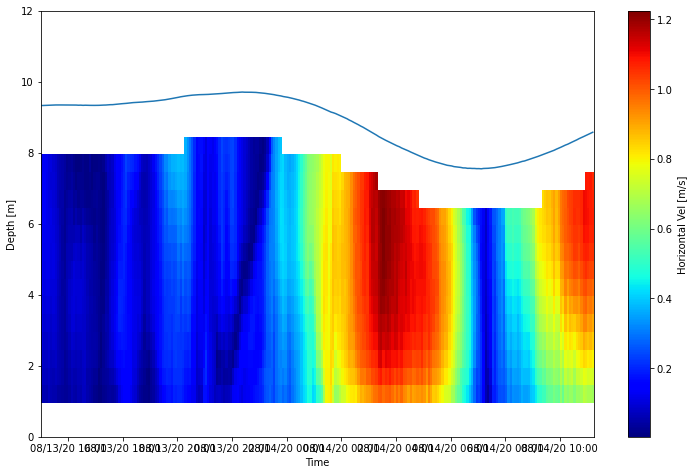

In [8]:
%matplotlib inline 
from matplotlib import pyplot as plt
import matplotlib.dates as dt

t = dlfn.time.epoch2date(dat_avg.time)

ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot the horizontal velocity magnitude
plt.pcolormesh(t, dat_avg.range, dat_avg.Veldata.U_mag, cmap='jet', shading='nearest')
# Plot the water surface
ax.plot(t, dat_avg.d_range)

# set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%D %H:%M'))

ax.set_ylabel('Depth [m]')
ax.set_ylim([0, 12]);
plt.colorbar(label='Horizontal Vel [m/s]');

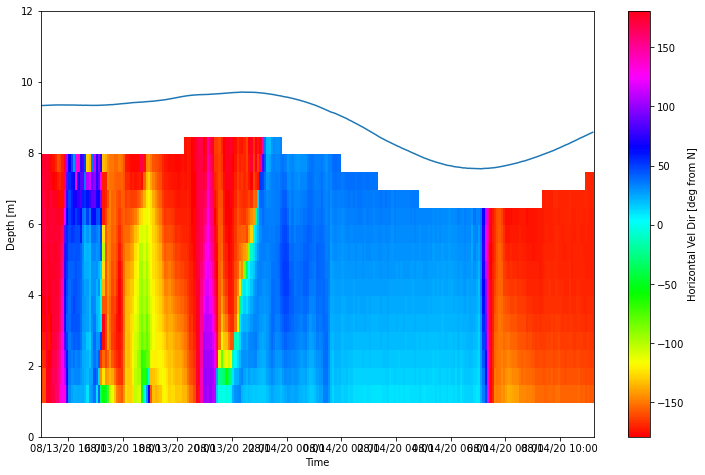

In [9]:
# Plot horizontal velocity direction
ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
plt.pcolormesh(t, dat_avg.range, dat_avg.Veldata.U_dir, cmap='hsv', shading='nearest')
# Plot the water surface
ax.plot(t, dat_avg.d_range)

# set up time on x-axis
ax.set_xlabel('Time')
ax.xaxis.set_major_formatter(dt.DateFormatter('%D %H:%M'))

ax.set_ylabel('Depth [m]')
ax.set_ylim([0, 12]);
plt.colorbar(label='Horizontal Vel Dir [deg from N]');